In [1]:
# Load libraries
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from npl_pet_lib import *
from segmentation_lib import get_neighbors, my_boundaries

In [2]:
# scanner geometry
R = 400
nc = 512
thet = 2.*np.pi/nc*np.arange(nc)
pc = R*np.array([np.cos(thet), np.sin(thet)]).T
# define recon space
dims = np.array((256, 256), dtype = np.int32)
px = 1.
delta = np.ones(2, dtype = np.float64)*px
ori = -.5*delta*dims
x = np.linspace(ori[0], ori[0]+(dims[0]+1)*px, num = dims[0]+1)
y = np.linspace(ori[1], ori[1]+(dims[1]+1)*px, num = dims[1]+1)
mask = np.zeros(dims, dtype = np.int32).ravel()
print('get edge neighbors...')
diagnorm = 2 # use diagonals : 1 to remove
neighbors, idxnb = get_neighbors(np.array(dims, dtype = np.int32), diagnorm, mask)

get edge neighbors...


In [3]:
# build system matrix
print('system matrix...')
idxsys, lor, system = build_system_matrix(pc, dims, ori, delta)

system matrix...
tot. syst. 8861226


In [4]:
# choice of colormap 
cmap = 'viridis'

load phantom...
create lesion
compute phantom mask
segments 184
condition number = 2.833e+02


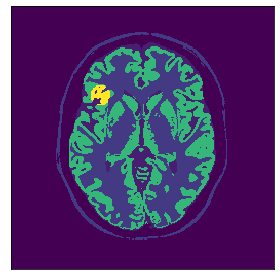

In [5]:
# load data
# Phantom
print('load phantom...')
phantom=np.zeros(dims, dtype = np.float64)
lesion=np.zeros(dims, dtype = bool)
# data_path = Path(os.path.dirname(os.path.realpath(__file__))) / 'data'
data_path = Path(os.getcwd()) / 'data'
# Choice of brain slice
slice=71
data=np.fromfile(data_path / "phantom_1.0mm_normal_crisp_181x217x181.rawb", dtype=np.uint8, count=-1).reshape(181,217,181)[slice]#
X,Y=np.meshgrid(np.arange(181),np.arange(217))
print('create lesion')
tumeur=(data==2)*(((X-50)**2+(Y-150)**2)<10**2)
ph = (data==1)*.5+(data==2)*4.+(data==3)*1.+((data==4)+(data==9))*1.+(data==8)*1.+tumeur*2. #Simon
oriph = (dims-ph.shape)//2
phantom[oriph[0]:oriph[0]+ph.shape[0],oriph[1]:oriph[1]+ph.shape[1]]=ph
lesion[oriph[0]:oriph[0]+ph.shape[0],oriph[1]:oriph[1]+ph.shape[1]]=tumeur[:]
# define profile across lesion
xprof = 150
# normalize scale
vm = max(phantom.ravel()/np.sum(phantom))
# Phantom
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.pcolormesh(x, y, phantom/np.sum(phantom), vmin = 0, vmax = vm, cmap = cmap)
fig1.tight_layout()
fig1.savefig(f'theo_phantom.png', bbox_inches='tight', dpi=300)
# Phantom mask
print('compute phantom mask')
mask_hull = np.nonzero(phantom.ravel())[0]
pts = np.moveaxis(np.meshgrid(np.arange(dims[0]),np.arange(dims[1]), indexing='ij'), 0, -1).reshape(-1, 2)
hull = ConvexHull(pts[mask_hull])
nbpts = len(pts)
lpts = np.c_[pts, np.ones(nbpts)].astype(np.float64)
ptsok = np.sum(lpts.dot(hull.equations.T) > 0, 1) == 0
listi = np.zeros(nbpts, dtype=np.int32)
listi[ptsok] = 1
mask = listi.reshape(dims)
# MRI data
raw_anat=np.fromfile(data_path / "t1_icbm_normal_1mm_pn3_rf20_181x217x181.raws", dtype=np.uint16, count=-1).reshape(181,217,181)[slice]#
data_anat=np.ones(dims, dtype = np.float64)*raw_anat[0,0]
data_anat[oriph[0]:oriph[0]+raw_anat.shape[0],oriph[1]:oriph[1]+raw_anat.shape[1]]=raw_anat
# load segmentations array
dict_tags = np.load(data_path / "anat_segmentations.npz")
tags = dict_tags['arr_0']
# choose last segmentation (arbitrary could be : tags[np.random.randint(len(tags))])
tag = tags[-1]*mask.ravel()
# get segmentation boundaries
lines = my_boundaries(tag.reshape(dims), np.arange(dims[1]).astype(np.float64),np.arange(dims[0]).astype(np.float64)).T
# segmented system matrix 
segment_frame = build_segment_frame(tags[-1,:], mask.ravel())
print('segments',len(segment_frame))
idxsys_z, lor_z, system_z, idxframe, lorframe, sysframe = frame_system_matrix(idxsys, lor, system, segment_frame)
# condition number of segmented system matrix
singular_values = system_condition_number(idxsys_z, lor_z, system_z)
condition_number = max(singular_values)/min(singular_values)#
print(f"condition number = {condition_number:.3e}")
# MRI + segments boudaries
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.pcolormesh(x, y, data_anat, vmin = 0, vmax = max(data_anat.ravel()), cmap = 'gray')
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
bounds, = ax1.plot(ori[0]+lines[0]*px, ori[1]+lines[1]*px, color='yellow', lw=0.5, alpha=1)#'crimson'
ax1.set_xlim([x[0],x[-1]])
ax1.set_ylim([y[0],y[-1]])
fig1.tight_layout()
fig1.savefig('mri_segment_figure.png', bbox_inches='tight', dpi=300)
###########################################

In [6]:
# Generate synthetic data
print('synthetic data generation...')
Lamb0 = 5.e5 # reference intensity for t=1.
t = 1. # accumulation time 
T = Lamb0*t
hsino = generate_data_sys(phantom.ravel(), idxsys, lor, system, Lamb0*t)
sino_ind = np.nonzero(hsino)[0].astype(np.int32)
sino_counts = hsino[sino_ind].astype(np.float64)
# plot data sinogram
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (6,6))
phys_sino, phi_sino, delta_sino = coord_physical_lor(pc, hsino)#
ax1.pcolormesh(delta_sino, phi_sino, phys_sino, cmap = cmap)#, 
ax1.set_title('Data sinogram')
ax1.set_xlim([-nc//4,nc//4])
ax1.set_xlabel('Shift')
ax1.set_ylabel('Angle')
fig1.tight_layout()
fig1.savefig(f'data_sinogram_t={t:.0f}.png', bbox_inches='tight', dpi=300)
#

synthetic data generation...
M 130816 19975


In [7]:
# MAP COSEM Parameters
#penalty
beta = 2e-3#1e-3#4.e-3
nu = 0.15#.25
eta = 20.#10.
beta_phantom = 1e-3
L = 100 # number of iterations
S = 4 # number of subsets
#

Achievable phantom from reconstruction of projected theoretical phantom
iter 0 llik 1146825.6759808138 1.0
iter 1 llik 1171212.5595187289 1.0
iter 2 llik 1181496.5266425728 1.0
iter 3 llik 1185778.3074742744 1.0
iter 4 llik 1187812.545479583 1.0
iter 5 llik 1188927.2826566105 1.0
iter 6 llik 1189629.3368147244 1.0
iter 7 llik 1190122.1029632525 1.0
iter 8 llik 1190491.5091368307 1.0
iter 9 llik 1190778.035337082 1.0
iter 10 llik 1191004.9865922683 1.0
iter 11 llik 1191187.8293462119 1.0
iter 12 llik 1191337.0820323383 1.0
iter 13 llik 1191460.4499877153 1.0
iter 14 llik 1191563.5234851998 1.0
iter 15 llik 1191650.398163051 1.0
iter 16 llik 1191724.3643816197 1.0
iter 17 llik 1191787.8361209072 1.0
iter 18 llik 1191842.6733059394 1.0
iter 19 llik 1191890.3655005076 1.0
iter 20 llik 1191932.1318838915 1.0
iter 21 llik 1191968.9262374844 1.0
iter 22 llik 1192001.4899402594 1.0
iter 23 llik 1192030.4569692225 1.0
iter 24 llik 1192056.335452452 1.0
iter 25 llik 1192079.5507678587 1.0
iter 2

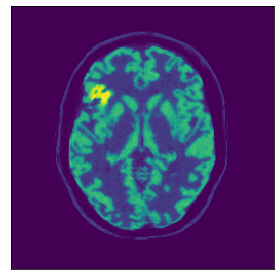

In [8]:
# "Achievable" phantom : map-cosem of projected phantom
gamma_phantom = segment_project(idxsys, lor, system, phantom.ravel()) 
gamma_phantom *= Lamb0/np.sum(gamma_phantom)
# print('sum gamma_phantom',np.sum(gamma_phantom))
sino_ind_phantom = np.nonzero(gamma_phantom)[0].astype(np.int32)
sino_counts_phantom = gamma_phantom[sino_ind_phantom].astype(np.float64)
print("Achievable phantom from reconstruction of projected theoretical phantom")
verbose = True
lambda_phantom = map_cosem_tomo(idxsys, lor, system, sino_ind_phantom, sino_counts_phantom, idxnb, neighbors, 
np.empty(0,dtype=np.float64), beta_phantom, eta, nu, S, L, verbose).reshape(dims)
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.pcolormesh(x, y, lambda_phantom/Lamb0, vmin = 0, vmax = vm, cmap = cmap)
fig1.tight_layout()
fig1.savefig(f'map_cosem_phantom_figure_beta={beta_phantom:.2e}.png', bbox_inches='tight', dpi=300)
# Profile phantom vs achievable 
fig2, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(.5*(x[1:]+x[:-1]),np.sum(lambda_phantom[oriph[0]+xprof:oriph[0]+xprof+1,:],axis=0)/Lamb0, label = 'Recon. phantom')#
ax2.plot(.5*(x[1:]+x[:-1]),np.sum(phantom[oriph[0]+xprof:oriph[0]+xprof+1,:],axis=0)/np.float64(np.sum(phantom)),alpha=.67,label = 'Phantom', linestyle='--')
ax2.set_xlim([x[0],x[-1]])
ax2.set_ylim([0.,1.6e-4])
fig2.savefig(f'profile_phantom_figure_beta={beta_phantom:.2e}.pdf', bbox_inches='tight')

MAP-COSEM recon...
iter 0 llik 1148208.0674328138 1.0
iter 1 llik 1173141.0718670783 1.0
iter 2 llik 1184503.776617801 1.0
iter 3 llik 1189058.8370677007 1.0
iter 4 llik 1191083.7504961167 1.0
iter 5 llik 1192142.6357954938 1.0
iter 6 llik 1192796.8744530014 1.0
iter 7 llik 1193262.3420103015 1.0
iter 8 llik 1193625.3265434888 1.0
iter 9 llik 1193918.833934449 1.0
iter 10 llik 1194159.7830818016 1.0
iter 11 llik 1194361.2413197246 1.0
iter 12 llik 1194530.6091513138 1.0
iter 13 llik 1194674.3544418782 1.0
iter 14 llik 1194797.3064261652 1.0
iter 15 llik 1194903.461633463 1.0
iter 16 llik 1194995.7069947398 1.0
iter 17 llik 1195076.474076019 1.0
iter 18 llik 1195147.6841194548 1.0
iter 19 llik 1195211.0075194382 1.0
iter 20 llik 1195267.609574191 1.0
iter 21 llik 1195318.547644797 1.0
iter 22 llik 1195364.6292740488 1.0
iter 23 llik 1195406.511233239 1.0
iter 24 llik 1195444.7761681492 1.0
iter 25 llik 1195479.8360735304 1.0
iter 26 llik 1195512.075479244 1.0
iter 27 llik 1195541.821395

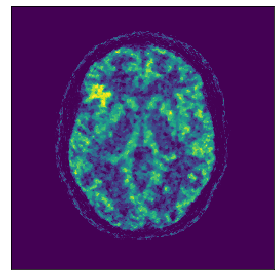

In [9]:
# MAP cosem recon
print('MAP-COSEM recon...')
verbose = True
lambda_mapcosem = map_cosem_tomo(idxsys, lor, system, sino_ind, sino_counts/t, idxnb, neighbors,
np.empty(0,dtype=np.float64), beta, eta, nu, S, L, verbose).reshape(dims)
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.pcolormesh(x, y, lambda_mapcosem/Lamb0, vmin = 0, vmax = vm, cmap = cmap)
fig1.tight_layout()
fig1.savefig(f'map_cosem_figure_beta={beta:.2e}.png', bbox_inches='tight', dpi=300)

NPL-COSEM recon...
iter npl 64
iter npl 96
iter npl 32
iter npl 0
iter npl 33
iter npl 65
iter npl 1
iter npl 97
iter npl 34
iter npl 66
iter npl 2
iter npl 98
iter npl 35
iter npl 67
iter npl 3
iter npl 99
iter npl 36
iter npl 68
iter npl 4
iter npl 100
iter npl 37
iter npl 69
iter npl 5
iter npl 101
iter npl 38
iter npl 70
iter npl 6
iter npl 102
iter npl 71
iter npl 39
iter npl 7
iter npl 103
iter npl 72
iter npl 40
iter npl 8
iter npl 104
iter npl 73
iter npl 41
iter npl 9
iter npl 105
iter npl 74
iter npl 42
iter npl 10
iter npl 106
iter npl 75
iter npl 43
iter npl 11
iter npl 107
iter npl 76
iter npl 44
iter npl 12
iter npl 108
iter npl 77
iter npl 45
iter npl 13
iter npl 109
iter npl 78
iter npl 46
iter npl 14
iter npl 110
iter npl 79
iter npl 47
iter npl 15
iter npl 111
iter npl 80
iter npl 48
iter npl 16
iter npl 112
iter npl 81
iter npl 49
iter npl 17
iter npl 113
iter npl 82
iter npl 50
iter npl 18
iter npl 114
iter npl 83
iter npl 51
iter npl 19
iter npl 115
iter npl 84
ite

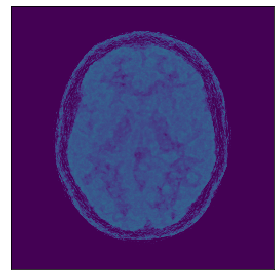

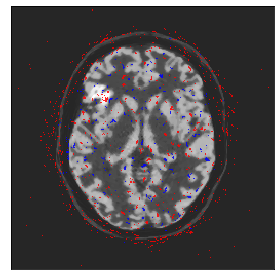

In [11]:
# Nonparametric posterior learning
print('NPL-COSEM recon...')
# fraction parameter (rho)
rho = 0.5#1.#0.25#2.#
# number of bootstrap samples
B = 128
#
mu_ini = np.empty(0, dtype = np.float64)
lambda_ini = np.empty(0, dtype = np.float64)
verbose = False
t0 = time.time()
lambda_npl = npl_map_cosem_anat_tomo(idxsys, lor, system, hsino, idxnb, neighbors, beta, eta, nu, S, L, B, t,
    rho, idxsys_z, lor_z, system_z, mu_ini, lambda_ini, verbose)
t1 = time.time()
print('duration', t1-t0)
print("Compute mean and std...")
lambda_mean_npl = np.mean(lambda_npl,axis=0).reshape(dims)
lambda_std_npl = np.std(lambda_npl, axis=0).reshape(dims)
# 
print("Compute credible bands...")
trace_lambda = np.moveaxis(lambda_npl, 0, -1).reshape(dims[0],dims[1],-1)
trace_lesion = np.array([np.mean(trace_lambda[:,:,b][lesion]) for b in range(B)])
# sort_lesion = np.sort(trace_lesion)
# print('mean/std lesion npl :',np.mean(trace_lesion)/Lamb0,np.std(trace_lesion)/Lamb0)
# print('lesion CI :',sort_lesion[int(.025*B)]/Lamb0,sort_lesion[int(.975*B)]/Lamb0)
sort_npl = np.sort(trace_lambda)
minCI = sort_npl[:,:,int(.025*B)]
maxCI = sort_npl[:,:,int(.975*B)]
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.pcolormesh(x, y, lambda_mean_npl/Lamb0, vmin = 0, vmax = vm, cmap = cmap)
fig1.tight_layout()
fig1.savefig(f'mean_npl_figure_t={t:.0f}_rho={rho:.2f}_beta={beta:.2e}.png', bbox_inches='tight', dpi=300)
#
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
gnpb,=ax1.plot(.5*(x[1:]+x[:-1]),np.sum(lambda_mean_npl[oriph[0]+xprof:oriph[0]+xprof+1,:],axis=0)/Lamb0, alpha = 1, label = 'Post. mean')#
ax1.fill_between(.5*(x[1:]+x[:-1]),minCI[oriph[0]+xprof]/Lamb0,maxCI[oriph[0]+xprof]/Lamb0,color = gnpb.get_color(),alpha=.25, label = r'''Post. 95% intervals''')
ax1.plot(.5*(x[1:]+x[:-1]),np.sum(lambda_phantom[oriph[0]+xprof:oriph[0]+xprof+1,:],axis=0)/Lamb0, linestyle = '--', label = 'Lambda phantom')
ax1.set_xlim([x[0],x[-1]])
ax1.set_ylim([0.,1.6e-4])
ax1.set_yticks([])
fig1.tight_layout()
fig1.savefig(f'profile_mean_npl_figure_t={t:.0f}_rho={rho:.2f}_beta={beta:.2e}.pdf', bbox_inches='tight')
#
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.pcolormesh(x, y, 3.*lambda_std_npl/Lamb0, vmin = 0, vmax = vm, cmap = cmap)
fig1.tight_layout()
fig1.savefig(f'std_npl_figure_t={t:.0f}_rho={rho:.2f}_beta={beta:.2e}.png', bbox_inches='tight', dpi=300)
#
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.pcolormesh(x, y, lambda_phantom/Lamb0, vmin = 0, vmax = vm, cmap = 'gray', alpha=.85, zorder = 2)
fail_CI = np.where(lambda_phantom<minCI-1e-16*Lamb0,0,np.where(lambda_phantom>maxCI, 1, np.nan))
ax1.pcolormesh(x, y, fail_CI, vmin = 0, vmax = 1, cmap = 'bwr', alpha=.85, zorder = 2.5)
fig1.tight_layout()
fig1.savefig(f'fail_CI_figure_t={t:.0f}_rho={rho:.2f}_beta={beta:.2e}.png', bbox_inches='tight', dpi=300)
#